# Handling Missing Data

## Initialize Environment

Set working directory

Specify required packages.

In [80]:
required_packages <- c(
  'reshape2',    # Flexibly restructure and aggregate data
#  'MASS',          # Example data sets
  'tidyverse',     # Data science packages collection
  'pastecs',       # Descriptive statistics
  'dplyr',         # Data manipulation
#  'knitr',         # Dynamic report generation
  'scales',        # Scale formatting
  'ggplot2',       # Plotting
#  'colorspace',    # Color palettes
  'wesanderson',   # Color palettes
  'gridExtra',     # Plotting
#  'caret',         # Data preprocessing
#  'stringi',       # String preprocessing
  'VIM',           # Missing data visualization
  'naniar',        # Missing data visualization
  'BaylorEdPsych', # Little's test fro MCAR missingness mechnism
  'mice'          # Multiple imputation
#  'mi',            # Multiple imputation
#  'betareg',       # Package required by MI to model proportions
#  'imputeTS',      # Time-series missing data imputation
#  'devtools'       # Loading packages from GitHub repos
)
print(required_packages)

 [1] "reshape2"      "tidyverse"     "pastecs"       "dplyr"        
 [5] "scales"        "ggplot2"       "wesanderson"   "gridExtra"    
 [9] "VIM"           "naniar"        "BaylorEdPsych" "mice"         


Load required packages (install missing packages if not already installed). 

In [81]:
#for (c in required_packages) require(c, character.only = TRUE)
for (package in required_packages){ 
  if (!require(package, character.only = TRUE, quietly = TRUE)) {
    install.packages(package, repos='http://cran.us.r-project.org', dependencies = TRUE)
    library(package, character.only = TRUE)
  }
};

## Load Data: 'Boston House Prices'

In [5]:
# Original complete data set
df <- readRDS("data/Boston_Original.rds")

In [6]:
head(df)

Crime,Land,Business,River,NOx,Rooms,Age,Distance,Highway,Tax,Teachers,Blacks,Population,Value
0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
0.02985,0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


In [7]:
# Incomplete (amputed) data set
mdf <- readRDS("data/Boston_MissingGeneratedByMICEAmputation_Uncoded.rds")

In [8]:
head(mdf)

Crime,Land,Business,River,NOx,Rooms,Age,Distance,Highway,Tax,Teachers,Blacks,Population,Value
,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
0.02729,0,7.07,0,---,7.185,61.1,-,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2
0.02985,0,2.18,0,0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7


## Identify Potentially Missing Values

### Identify data entries, which may represent missing values

In [9]:
# Identify 'empty' data entries, which may intid´cate missing values.
empty_strings <- sort(
                    unique(
                      unlist(
                        unname(
                          lapply(mdf, function(x) x[!grepl("^[[:alpha:]]|^[[:digit:]]", x) | is.na(x)])
                        )
                      )
                    ), na.last = TRUE
                  )
cat ("Data entries potentially representing missing data:", empty_strings)

Data entries potentially representing missing data:  - ---   . _ NA

### Analyze potenitally missing data entries 

In [10]:
# Initilize data frame: Missing-Data-Codings x Features-in-Data-Set
# to count different codings of "empty" cells in the 'mdf' data set
empty_counts <- setNames(data.frame(
  matrix(data = 0, ncol = ncol(mdf), nrow = length(empty_strings)+1)), colnames(mdf))

# Name rows: each row dedicated to one coding of missing values
row_names <- append(empty_strings, "Complete", after = length(empty_strings))
row_names[is.na(row_names)] <- "<NA>"
row_names[row_names == ""] <- "\"\""
row_names[row_names == " "] <- "\" \""

rownames(empty_counts) <-  row_names

# Count missing value codding in the data set
for (i in 1:length(empty_strings)){
  if (!is.na(empty_strings[i]))
    empty_counts[i, ] <- lapply(mdf, function(x) sum(x == empty_strings[i], na.rm = TRUE))
  else
    empty_counts[i, ] <- lapply(mdf, function(x) sum(is.na(x)))
}
                                
# Finally, count the number of complete (non-empty) values per column
empty_counts[length(empty_strings) + 1, ] <- lapply(empty_counts, function(x) nrow(mdf) - sum(x[1:length(empty_strings)]))

# Reorder features according to the amout of complete cases
empty_counts <- empty_counts[,order(-empty_counts[nrow(empty_counts),])]

# Visualize missing ('empty') data values
long_empty_counts <- melt(as.matrix(empty_counts))

### Visualize portions of potentially missing data

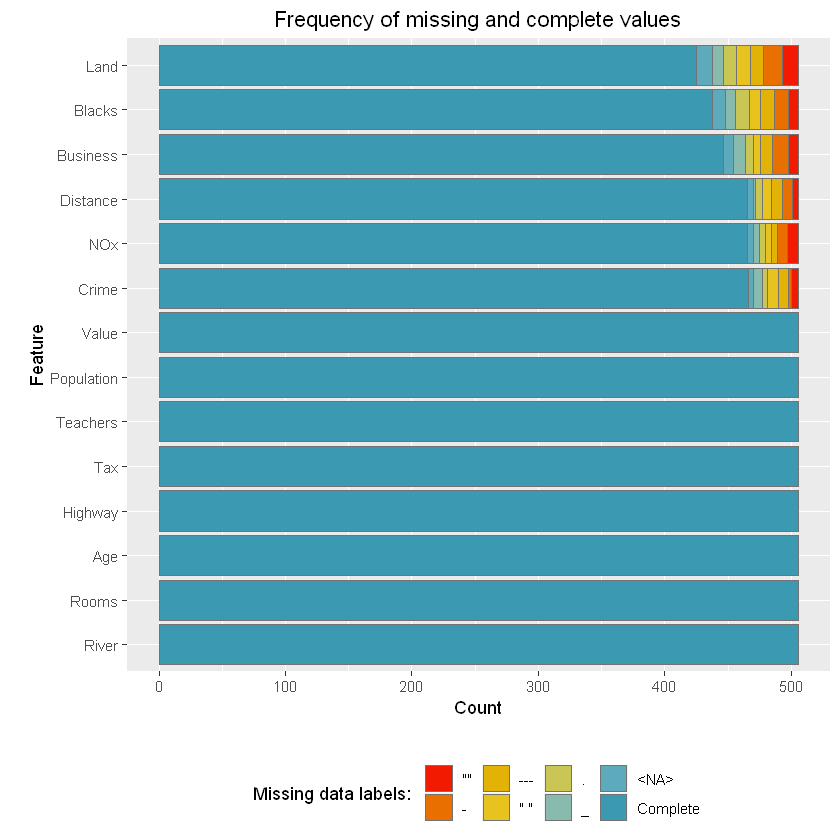

In [11]:
ggplot(data = long_empty_counts) +
  geom_bar(aes_string(x = "Var2", y = "value", fill = "Var1"), colour="#737373", stat = "identity") +
  ggtitle("Frequency of missing and complete values") +
  xlab("\nFeature") +
  ylab("Count\n") +
  coord_flip() +
  scale_fill_manual(values = rev(wes_palette("Zissou1", n = nrow(empty_counts), type = "continuous")), name = "Missing data labels: ") +
  theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5))

## Code missing values consistently

In [12]:
# Code missing data using 'NA'
mdf <- as.data.frame(lapply(mdf, function(x) gsub(x = x, pattern = "^[^[:alpha:][:digit:]]*$", 
                                                  replacement = NA, perl = TRUE)), 
                     stringsAsFactors = FALSE)
# Set data types of features
mdf <- data.frame(lapply(mdf, as.numeric))

## Analyze Volume and Pattern of Missing Data

### Compute total amount of missing values.

In [13]:
# Function to compute total count of missing cells in a data frame
missing_count_total <- function (df){
  return(sum(is.na(df)))
}
# Function to compute total ratio of missing cells in a data frame 
missing_portion_total <- function (df){
  portion <- (sum(is.na(df)) / (nrow(df) * ncol(df)))
  return(round(portion, digits = 2))
}

In [14]:
cat("Valume of missing data: \n",
    "Total count of missing data:", missing_count_total(mdf), "\n", 
    "Total percentage of missing data:", missing_portion_total(mdf) * 100, "%")

Valume of missing data: 
 Total count of missing data: 331 
 Total percentage of missing data: 5 %

### Compute portions of missing data per feature.

In [15]:
# Function to cout missing values per data frame column
missing_portion_per_feature <- function (df){
  propNA <- sapply(df,function(x) round((sum(is.na(x)) / length(x)) * 100, digits = 2))
  propNA <- setNames(as.data.frame(propNA), c("Missing_Ratio"))
  pNA <- data.frame ("Attribute" = rownames(propNA))
  pNA$Missing_Ratio <- propNA$Missing_Ratio
  pNA <- pNA[with(pNA, order(-Missing_Ratio)), ]
  colnames(pNA) <- c("Feature", "Missing %")
  
  return(pNA)
}

In [16]:
missing_portion_per_feature(mdf)

,Feature,Missing %
2,Land,16.01
12,Blacks,13.44
3,Business,11.86
5,NOx,8.10
8,Distance,8.10
1,Crime,7.91
4,River,0.00
6,Rooms,0.00
7,Age,0.00
9,Highway,0.00


### Analyze and visualize missing data pattern

In [17]:
## Prepare summary matrix of missing and observed values
missing_values <- mdf %>%
  gather(key = "key", value = "val") %>%
  mutate(isna = is.na(val)) %>%
  group_by(key) %>%
  mutate(total = n()) %>%
  group_by(key, total, isna) %>%
  summarise(missing_count = n()) %>%
  mutate(missing_ratio = missing_count / total)

## Sort featues according to the amount of missing values
levels <- (missing_values  %>% 
             #filter(isna == TRUE) %>%     
             arrange(desc(missing_ratio)))$key %>%
          unique()

#### Create plot for missing data portions using bar chart.

In [18]:
missing_percentage_plot <- missing_values %>%
  ggplot(aes(x = reorder(key, desc(missing_ratio)), 
             y = missing_ratio, fill = isna, label = paste0(round(missing_ratio * 100, 1), "%"))) +
  geom_bar(stat = 'identity', alpha = 0.8) +
  geom_text(size = 3, position = position_stack(vjust = 0.5)) +
  scale_x_discrete(limits = levels) +
  scale_y_continuous(labels = percent) +
  scale_fill_manual(name = "", 
                    values = c('steelblue', 'tomato3'), 
                    labels = c("Present", "Missing")) +
  labs(title = "Percentage of missing values", 
       x = 'Feature', y = "% of missing values") +
  theme(legend.position = "bottom") +
  coord_flip()
#missing_percentage_plot

#### Create plot for missing values patterns.

In [19]:
missing_pattern_plot <- mdf %>%
  mutate(id = row_number()) %>%
  gather(-id, key = "key", value = "val") %>%
  mutate(isna = is.na(val)) %>%
  ggplot(aes(x = key, y = id, fill = isna)) +
  geom_raster(alpha=0.8) +
  scale_fill_manual(name = "",
                    values = c('steelblue', 'tomato3'),
                    labels = c("Present", "Missing")) +
  scale_x_discrete(limits = levels) +
  labs(x = "Feature",
       y = "Case", title = "Missing values pattern") +
  theme(legend.position = "bottom") +
  coord_flip()
#missing_pattern_plot

#### Combine missing data portions and patterrn plots.

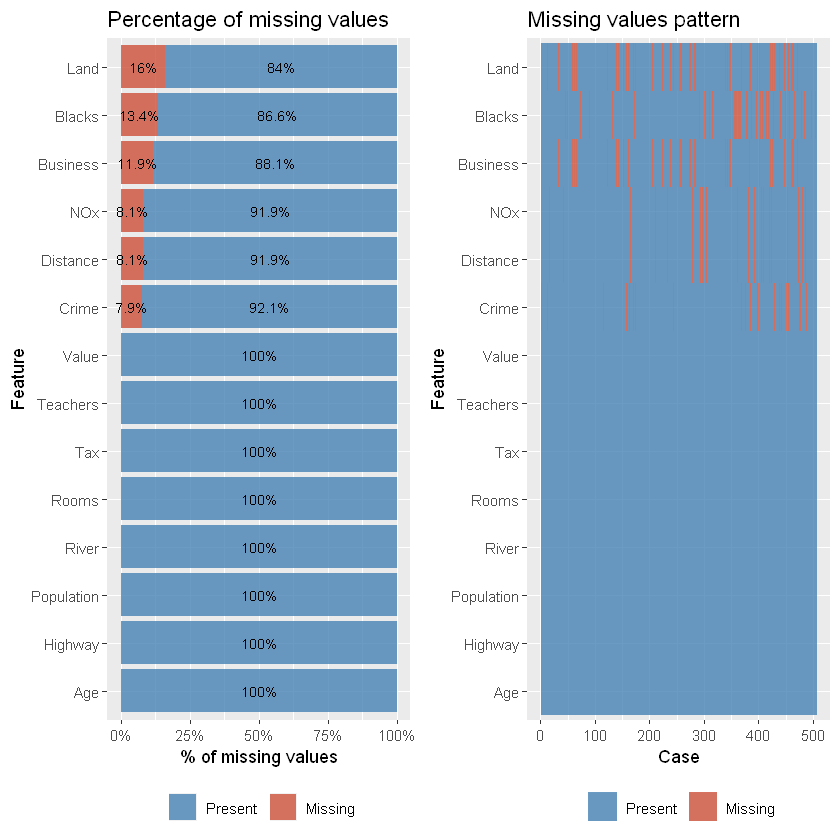

In [20]:
grid.arrange(missing_percentage_plot, missing_pattern_plot, ncol = 2)

### Visualize missingness pattern using 'VIM' package.

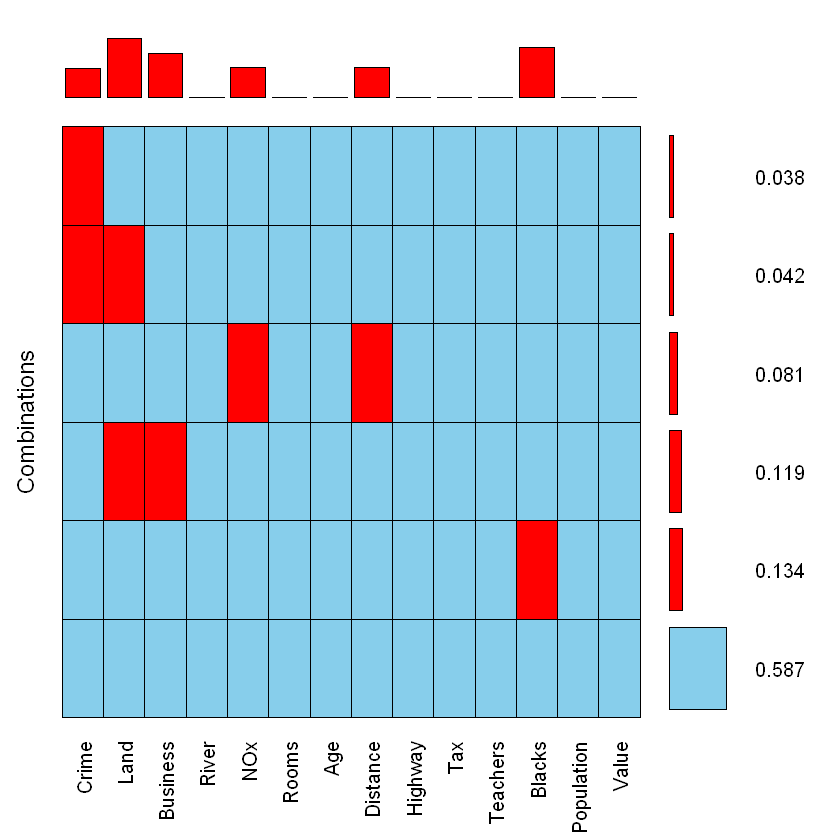

In [21]:
aggr(mdf, combined = TRUE, numbers = TRUE)

### Visualize combinations of missingness across cases using 'naniar' package.
Analysis of relationships between sets (case-wise) of missing data on features. 

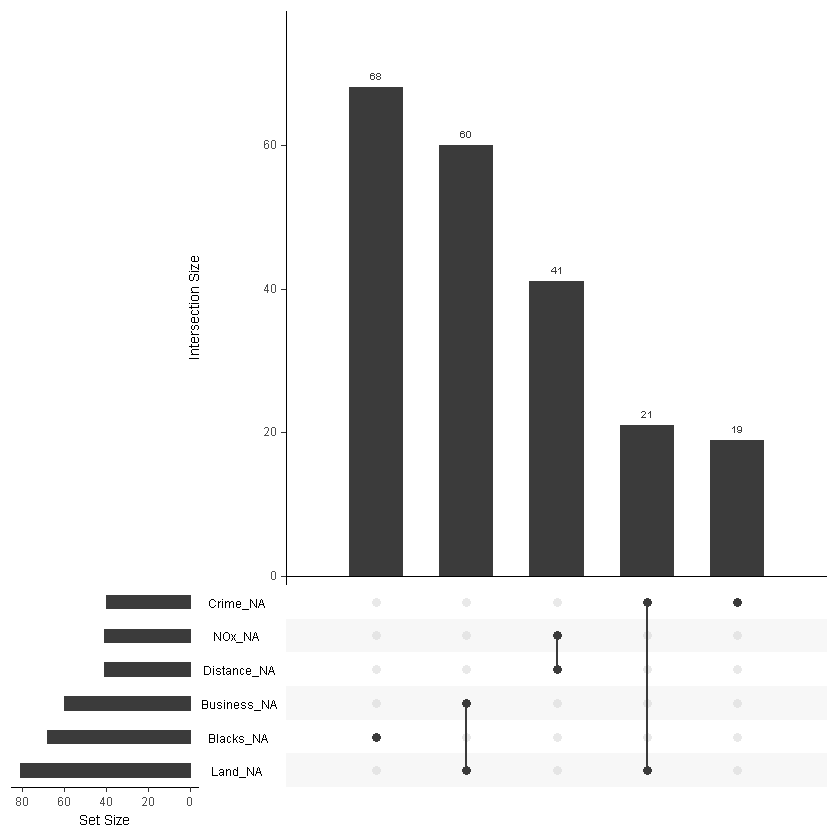

In [22]:
gg_miss_upset(mdf, nsets = n_var_miss(mdf))

__Example interpretation__: 'Land' has the most missing values. There are 60 cases where both 'Business' and 'Land' have missing values together. 

## Analyze Missingness Mechanism
- __Missing completely at random (MCAR):__ probability of missing data on a feature Y is unrelated to any other features and is unrelated to the values of Y itself.
- __Missing at random (MAR):__ the probability of missing data on a feature Y is related to some other measured features in the data but not to the values of Y itself.
- __Missing not at random (MNAR):__ probability of missing data on a feature Y is related to the values of Y itself.

<font color=red>Warning:</font> Missingness mechanism cannot be determined definitively because missing values are not known. Existing analysis methods may only give an indication of probable mechanism.

### Draw density plots for missing data.
Does distribution of missing data on a feature correlate with complete values of other features (MAR vs. MCAR)?

<font color=blue>Question:</font> Is missing data for 'Crime rate' related to the whether the data refer to business or habitat areas of Boston?

Warning message:
"Removed 60 rows containing non-finite values (stat_density)."

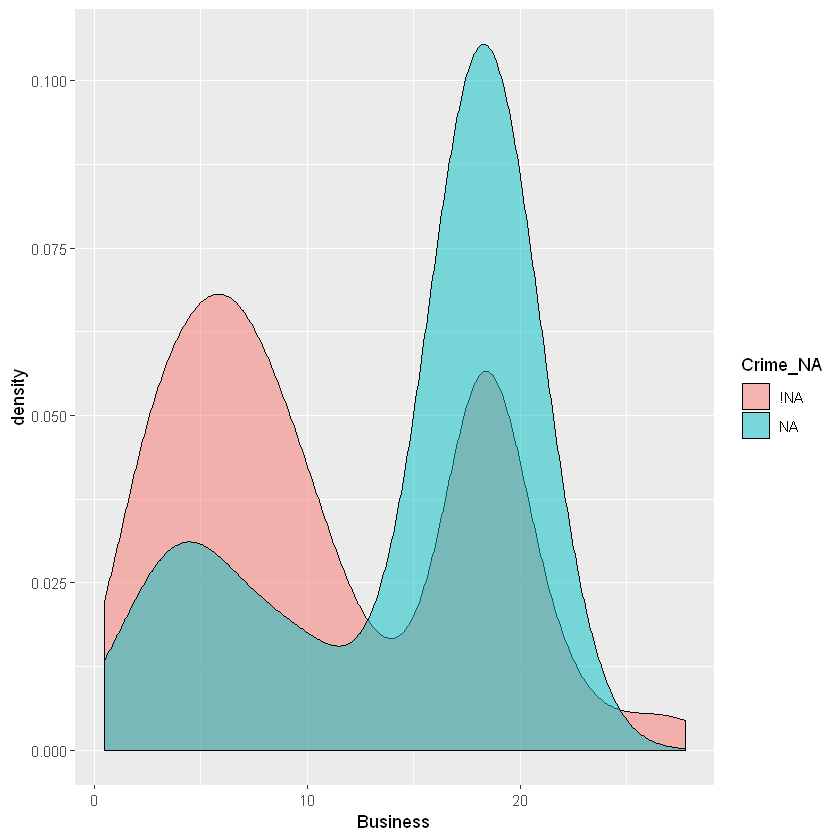

In [23]:
mdf %>%
  bind_shadow() %>%
  ggplot(aes(x = Business, fill = Crime_NA)) + 
  geom_density(alpha = 0.5)

<font color=blue>Question:</font> Is missing data for 'Crime rate' related to how old are areas (buildings) of Boston?

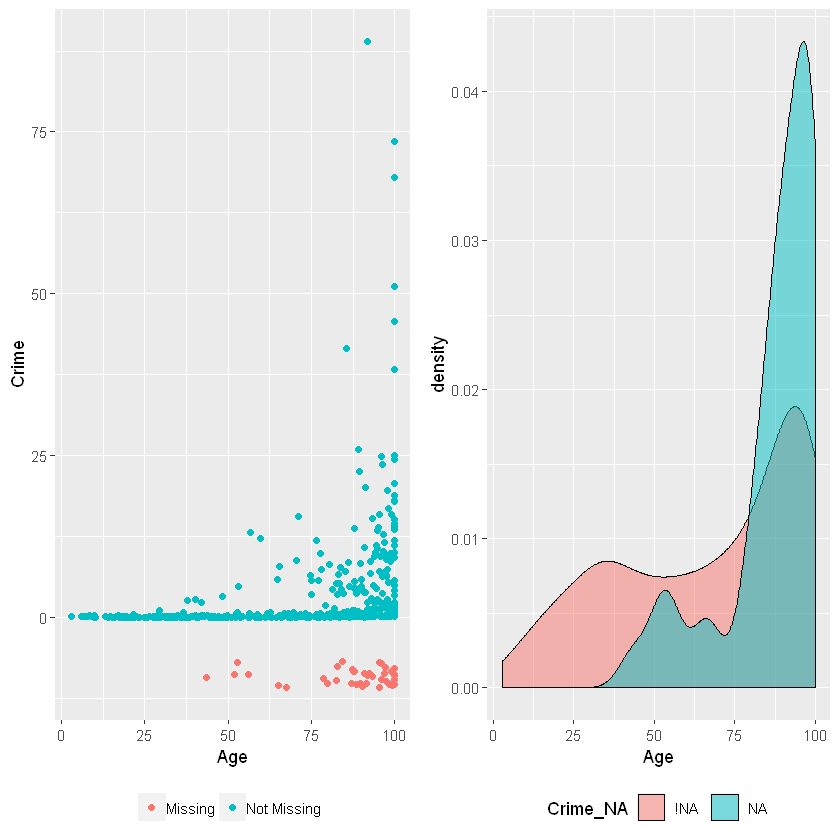

In [25]:
scatter <- ggplot(data = mdf, aes_string(x = "Age", y = "Crime")) +
  geom_miss_point() +
  theme(legend.position = "bottom", legend.title = element_blank())

density <- mdf %>%
  bind_shadow() %>%
  ggplot(aes(x = Age, fill = Crime_NA)) + 
  geom_density(alpha = 0.5) +
  theme(legend.position = "bottom")

grid.arrange(scatter, density, ncol = 2)

### Statistical test of missingess (Little's Test)
Little's Chi-Square test for MCAR.
Null hypothesis (H0): Data is MCAR.
IF p < 0.05 THEN H0 can be rejected (data is not MCAR).

In [27]:
#options (warn = -1)
features <- c('Age', 'Business', 'Crime')
little_test <- LittleMCAR(mdf[, features])
little_test_outome <- ifelse (little_test$p.value < 0.05, "not MCAR", "MCAR")
cat(
  "\nLittle test results for the following features:", paste(features, collapse = ', '), "\n",
  "Number of missing patterns:", little_test$missing.patterns, "\n",
  "Statistic value (chi):", round(little_test$chi.square, 1), "\n",
  "Significance level (p): ", little_test$p.value, "\n",
  "Conclusion: The data is", little_test_outome)
#options (warn = 1)

this could take a while
Little test results for the following features: Age, Business, Crime 
 Number of missing patterns: 3 
 Statistic value (chi): 24.1 
 Significance level (p):  7.745135e-05 
 Conclusion: The data is not MCAR

## Handle Missing Data
__Analyze outcomes for example features: Distance, NOx__

Define usefull functions.

In [103]:
# Compute basic statistics for numeric vectors
get_stats <- function (num_vec, header){
  stats <- data.frame(Stats = c('Min', 'Max', 'Mean', 'Median', 'StDev'),
                      Value = c(min(num_vec), 
                               max(num_vec), 
                               mean(num_vec), 
                               median(num_vec), 
                               sd(num_vec))
                      )
  colnames(stats)[2] <- header
  stats[, header] <- round(stats[, header], 2)
  return(stats)
}

# Create violin plot to visualize distribution of complete and missing/imputed data
plot_violin <- function (df, ind_var, grp_var, title){
  #df_stats <- get_stats(df[,ind_var], ind_var)

  #stats_tab <- tableGrob(df_stats, rows = NULL, theme = ttheme_default(base_size = 10))

  plt <- ggplot(df, aes_string(x = 1, y = ind_var, colour = grp_var)) +
           geom_violin(colour = "grey60", fill = "grey90") +
           geom_point (size = 3, position = position_jitter(width = 0.2, height = 0.0), alpha = 0.3) +
           scale_color_manual(values=c("blue", "red")) +
           ggtitle(title) + labs (color = "Missing") +
           theme(panel.background = element_rect(fill = "grey95", colour = "grey60"), 
                 axis.title.x=element_blank(), axis.text.x=element_blank(),
                 axis.ticks.x=element_blank(), legend.position = "bottom",
                 plot.title = element_text(hjust = 0.5)) #+
           #annotation_custom(stats_tab, xmax=2.2, ymin=2/3*max(df[,ind_var]))#xmin=0.7, xmax=2, ymin=8.9, ymax=12)
  return(plt)
}

Create reference plot of complete data

In [104]:
# Derive table with logical indicators of missing values (it is required by scattMiss plotting)
mdfm <- as.data.frame(is.na(mdf))
colnames(mdfm) <- paste(colnames(mdf), "imp", sep = "_")

# Select example feature to visualize
ind_var <- "Distance"
grp_var <- "Distance_imp"

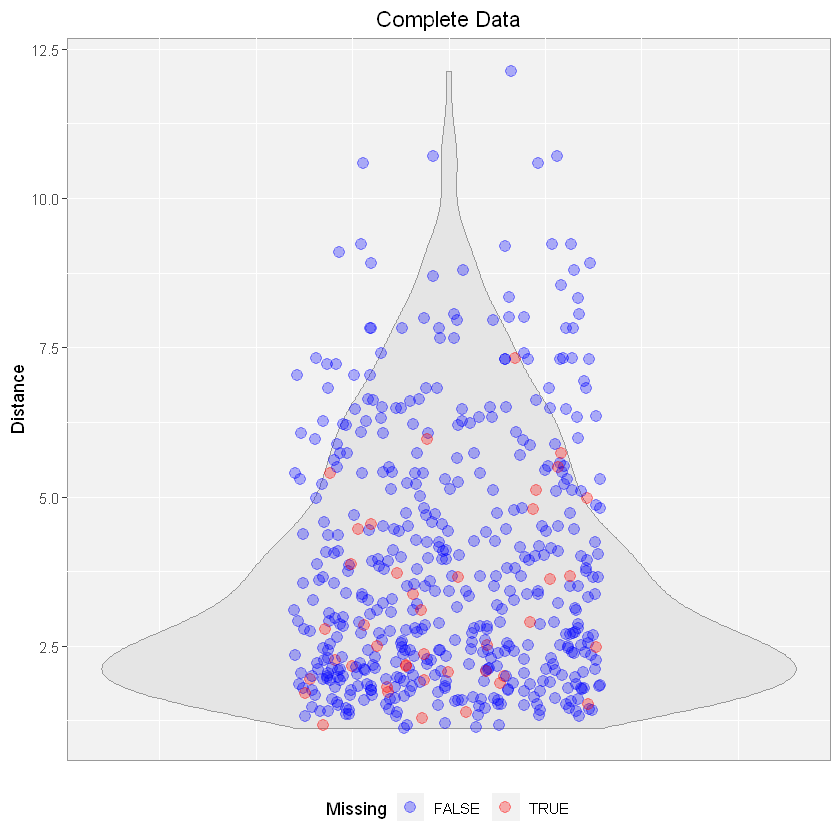

In [105]:
# Prepare data: add to data information about missing 
df_md <- df
df_md[, grp_var] <- mdfm[, grp_var]

# Plot complete data and highlight imputed (previously) missing data points
df_plt <- plot_violin(df_md, ind_var, grp_var, "Complete Data")
df_plt

In [106]:
df_stats <- get_stats(df[,ind_var], "Original")
df_stats

Stats,Original
Min,1.13
Max,12.13
Mean,3.80
Median,3.21
StDev,2.11


### Listwise delection

In [107]:
lwd_df <- mdf[complete.cases(mdf), ]

cat("Data reduction due to list-wise deletion:\n",
    "Number of cases before:", nrow(mdf), "\n",
    "Number of cases after:", nrow(lwd_df), "\n", 
    "Reduction of cases by:", round(nrow(lwd_df) / nrow(mdf) * 100, 1), "%")

Data reduction due to list-wise deletion:
 Number of cases before: 506 
 Number of cases after: 297 
 Reduction of cases by: 58.7 %

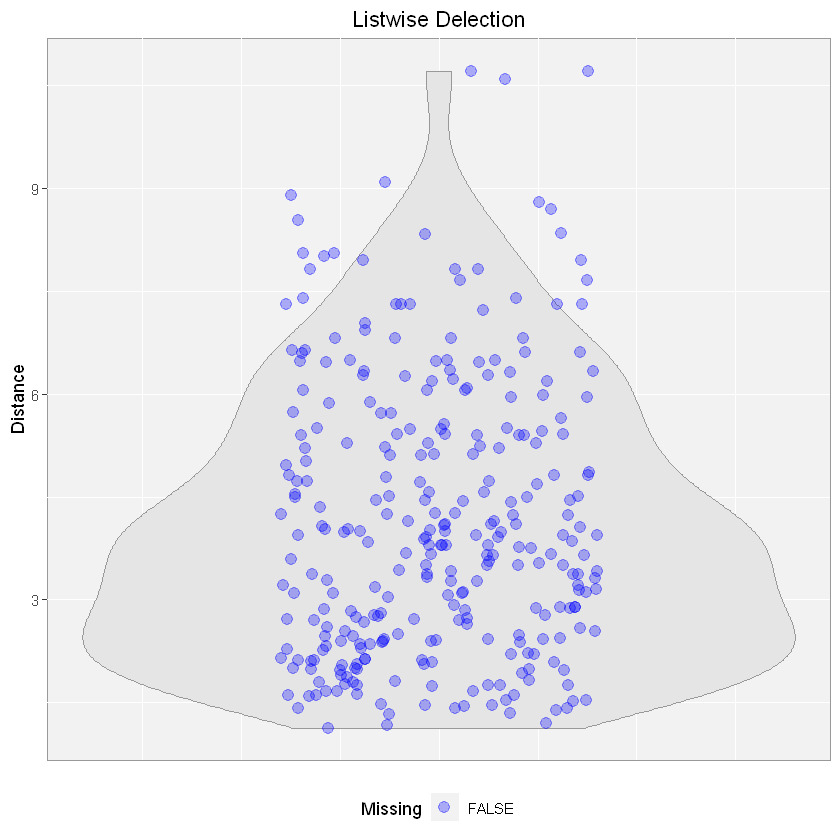

In [108]:
# Prepare data: add to data information about missing 
lwd_df[, grp_var] <- FALSE

# Plot complete data and highlight imputed (previously) missing data points
plt_lwd <- plot_violin(lwd_df, ind_var, grp_var, "Listwise Delection")
plt_lwd

In [109]:
lwd_stats <- get_stats(lwd_df[,ind_var], "LWD")
lwd_stats <- cbind(df_stats, lwd_stats["LWD"])
lwd_stats

Stats,Original,LWD
Min,1.13,1.13
Max,12.13,10.71
Mean,3.80,4.15
Median,3.21,3.84
StDev,2.11,2.03


### Mean Imputation

In [110]:
mean_imp_df <- as.data.frame(
  lapply(mdf, function(x) replace(x, is.na(x), mean(x, na.rm = TRUE)))) %>% bind_rows()

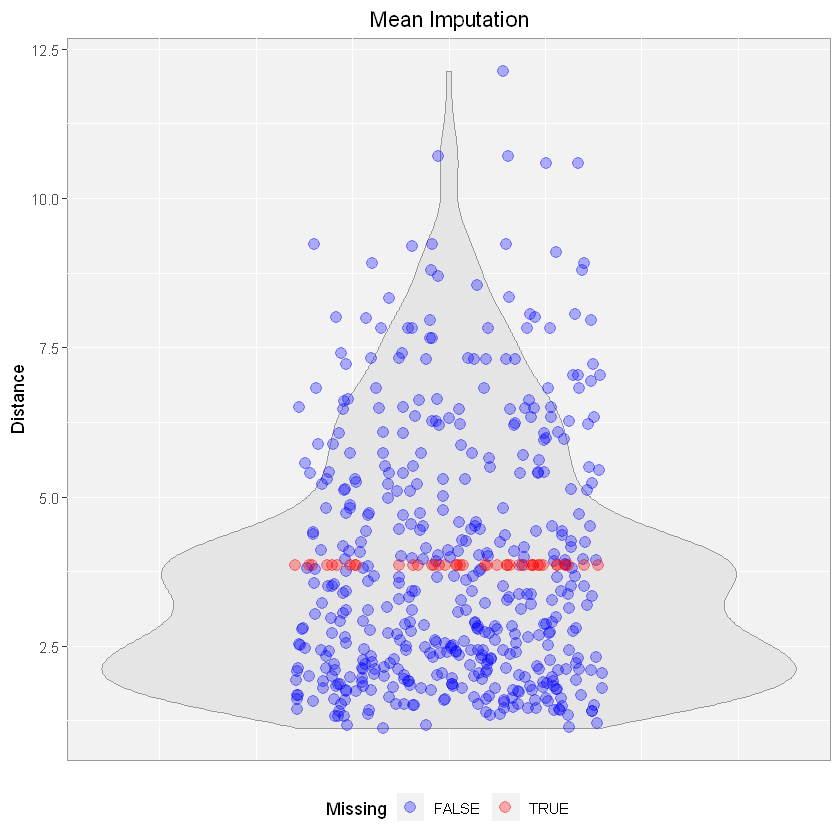

In [111]:
# Prepare data
mean_imp_df[, grp_var] <- mdfm[, grp_var]

# Plot complete data and highlight imputed (previously) missing data points
plt_mean_imp <- plot_violin(mean_imp_df, ind_var, grp_var, "Mean Imputation")
plt_mean_imp

In [112]:
mean_stats <- get_stats(mean_imp_df[,ind_var], "Mean_Imp")
mean_stats <- cbind(df_stats, mean_stats["Mean_Imp"])
mean_stats

Stats,Original,Mean_Imp
Min,1.13,1.13
Max,12.13,12.13
Mean,3.80,3.85
Median,3.21,3.54
StDev,2.11,2.05


### Hot-Deck Randomized Imputation

In [113]:
hdr_imp_df <- VIM::hotdeck(mdf, imp_var = TRUE, imp_suffix = "imp")

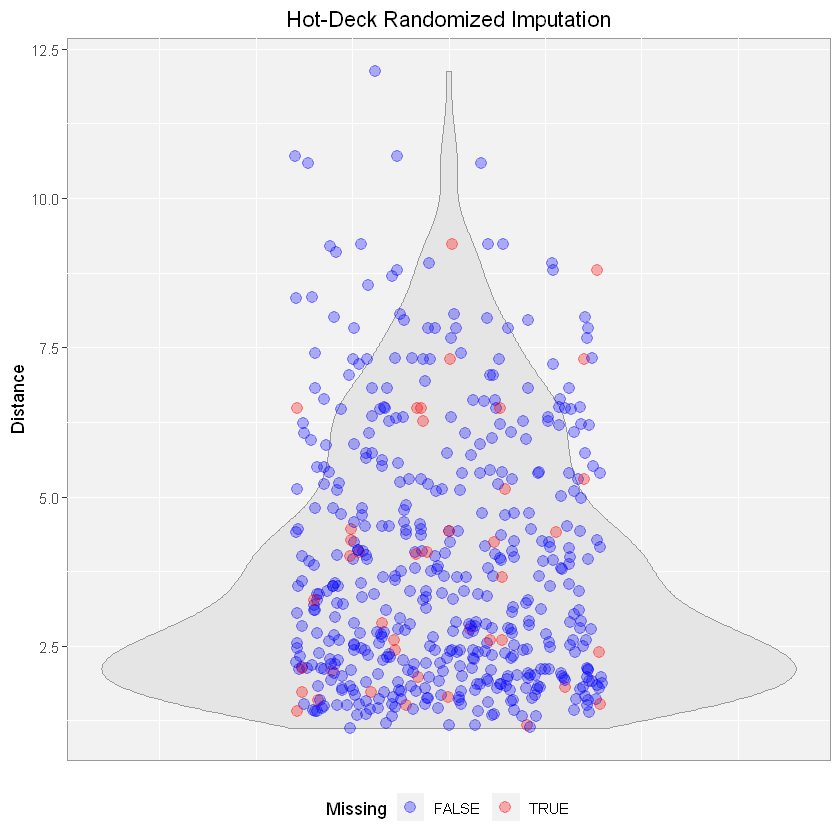

In [114]:
# Plot complete data and highlight imputed (previously) missing data points
plt_hdr_imp <- plot_violin(hdr_imp_df, ind_var, grp_var, "Hot-Deck Randomized Imputation")
plt_hdr_imp

In [115]:
hdr_stats <- get_stats(hdr_imp_df[,ind_var], "HDR_Imp")
hdr_stats <- cbind(df_stats, hdr_stats["HDR_Imp"])
hdr_stats

Stats,Original,HDR_Imp
Min,1.13,1.13
Max,12.13,12.13
Mean,3.80,3.85
Median,3.21,3.28
StDev,2.11,2.14


### Hot-deck k-Nearest-Neighbours Imputation

In [116]:
knn_imp_df <- VIM::kNN(mdf, imp_var = TRUE, imp_suffix = "imp")

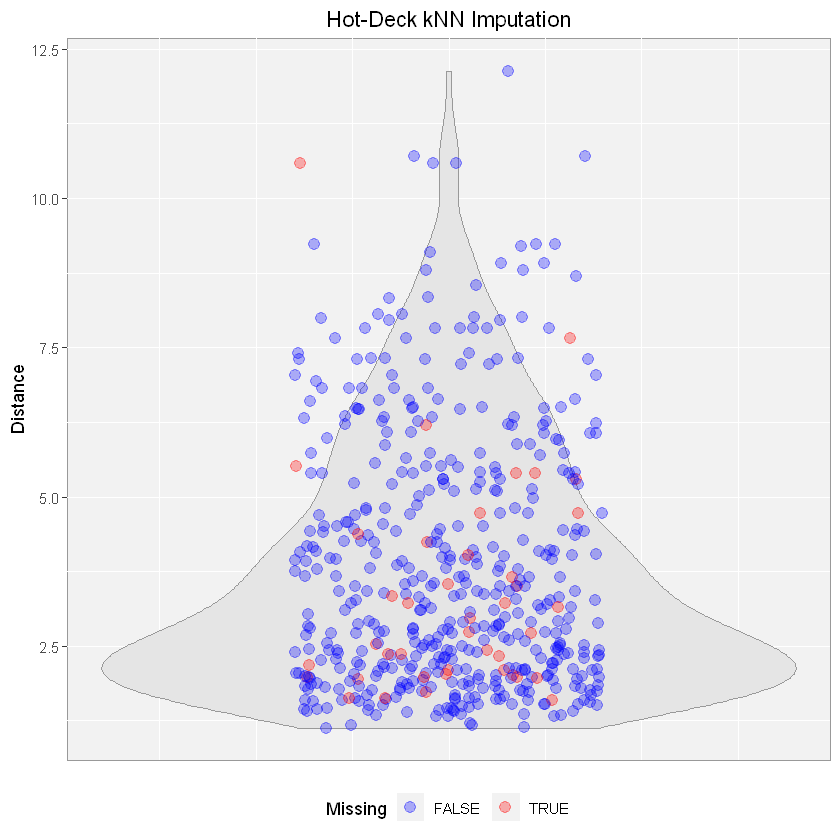

In [117]:
# Plot complete data and highlight imputed (previously) missing data points
plt_knn_imp <- plot_violin(knn_imp_df, ind_var, grp_var, "Hot-Deck kNN Imputation")
plt_knn_imp

In [118]:
knn_stats <- get_stats(knn_imp_df[,ind_var], "kNN_Imp")
knn_stats <- cbind(df_stats, knn_stats["kNN_Imp"])
knn_stats

Stats,Original,kNN_Imp
Min,1.13,1.13
Max,12.13,12.13
Mean,3.80,3.82
Median,3.21,3.22
StDev,2.11,2.12


### Regression Imputation

In [119]:
## Identify complete and incomplete features
incomplete_features <- colnames(mdf)[colSums(is.na(mdf)) > 0]
complete_features <- colnames(mdf)[colSums(is.na(mdf)) == 0]

## Create regression formula: y: incomplete features, x: compelte features
regr_formula <- as.formula(paste0(
  paste(incomplete_features, collapse = "+"), " ~ ", paste(complete_features, collapse = "+")))

## Run imputation: returns only the imputed incomplete features
reg_imp_df <- VIM::regressionImp(data = mdf, formula = regr_formula, imp_var = TRUE, imp_suffix = "imp")

## Add complete features to get complete data set (all original features)
reg_imp_df <- cbind(reg_imp_df, df_md[!names(df_md) %in% names(reg_imp_df)])

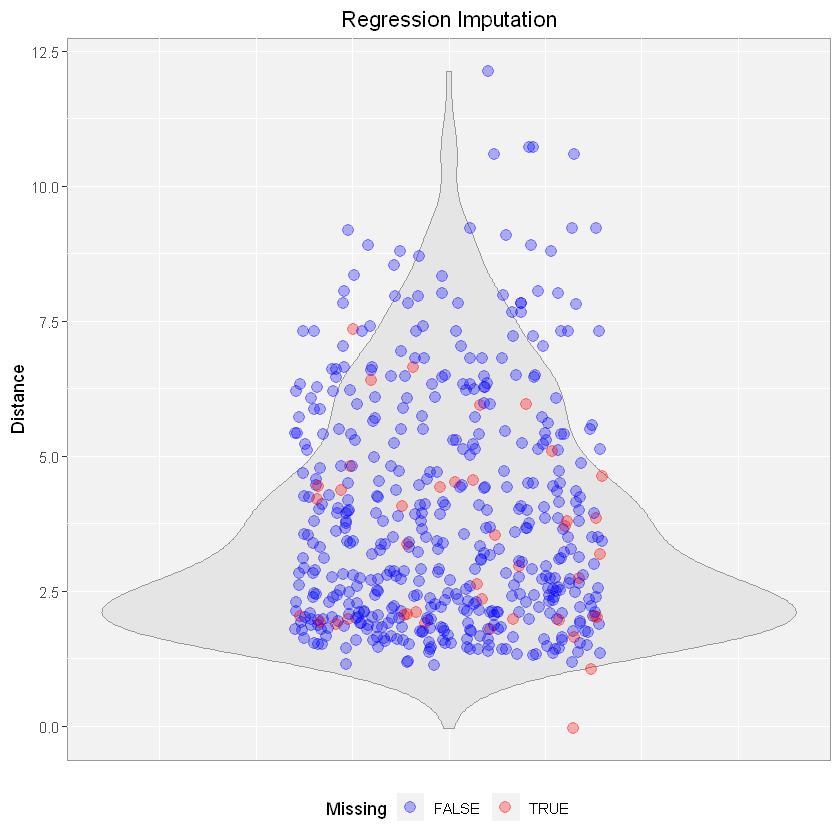

In [120]:
# Plot complete data and highlight imputed (previously) missing data points
plt_reg_imp <- plot_violin(reg_imp_df, ind_var, grp_var, "Regression Imputation")
plt_reg_imp

In [121]:
reg_stats <- get_stats(reg_imp_df[,ind_var], "Reg_Imp")
reg_stats <- cbind(df_stats, reg_stats["Reg_Imp"])
reg_stats

Stats,Original,Reg_Imp
Min,1.13,-0.04
Max,12.13,12.13
Mean,3.80,3.81
Median,3.21,3.27
StDev,2.11,2.11


### Comparison of the prepared datasets

#### Data distribution

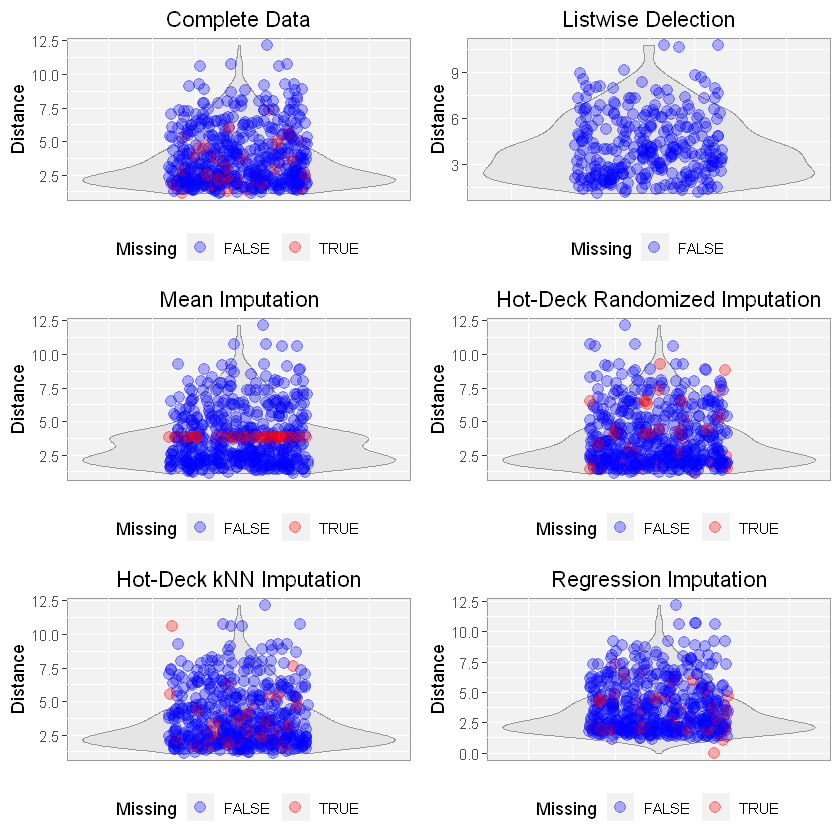

In [122]:
grid.arrange(df_plt, plt_lwd, plt_mean_imp, plt_hdr_imp, plt_knn_imp, plt_reg_imp, ncol = 2)

#### Basic statistics

In [123]:
df_stats <- cbind(df_stats, lwd_stats["LWD"], mean_stats["Mean_Imp"], hdr_stats["HDR_Imp"], knn_stats["kNN_Imp"], reg_stats["Reg_Imp"])
df_stats

Stats,Original,LWD,Mean_Imp,HDR_Imp,kNN_Imp,Reg_Imp
Min,1.13,1.13,1.13,1.13,1.13,-0.04
Max,12.13,10.71,12.13,12.13,12.13,12.13
Mean,3.80,4.15,3.85,3.85,3.82,3.81
Median,3.21,3.84,3.54,3.28,3.22,3.27
StDev,2.11,2.03,2.05,2.14,2.12,2.11
